# MFPT Classification Model

Continuando con el procesamiento de datos de la clase anterior, en este workshop volveremos a trabajar con el [Bearing Fault Dataset](https://www.mfpt.org/fault-data-sets/) de la MFPT. No obstante, ahora nos concentraremos en la construcción e implementación de modelos de clasificación de deep learning mediante `TensorFlow`.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/tensorflow.png" width="400">

`TensorFlow`, en términos generales, consiste en un framework diseñado para desarrollar e implementar algoritmos de Machine Learnine, y por supuesto, entre ellos, modelos de Deep Learning. Una de las particulares de este framework es que ofrece toda una gama de niveles de abstracción, desde el desarrollo de modelos de mayor complejidad mediante herramientas `low-level`, hasta la compilación y el entrenamiento de arquitecturas mediante estructuras `high-level`, como la API Keras.

Puede encontrar la documentación de estas librerías en los siguientes links:
- https://www.tensorflow.org/api_docs/python/
- https://keras.io/api/


In [2]:
!git clone https://github.com/cherrerab/deeplearningfallas.git
%cd /content/deeplearningfallas

Cloning into 'deeplearningfallas'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 202 (delta 25), reused 0 (delta 0), pack-reused 134
Receiving objects: 100% (202/202), 2.47 MiB | 18.31 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/deeplearningfallas


---
# Training Data

Nuevamente debemos preparar y reestructurar los datos del dataset para generar los sets de entrenamiento `(X_train, Y_train)` y validación `(X_val, Y_val)` que utilizaremos para entrenar nuestros modelos. Del mismo modo que en el workshop anterior, extraremos ventanas de datos de las series del dataset mediante la función `get_time_windows`. No obstante, modificaremos esta para permitir que exista superposición o un traslapo entre las ventanas. De esta manera será posible extraer más ventanas desde las series originales.

In [3]:
import numpy as np
import pandas as pd

def get_time_windows(data, nperwd, nleap):
  """
  -> np.array

  generates a numpy array of time windows, of length nperwd, extracted
  from data.

  :param pd.Series data:
    time series of measurement values.
  :param int nperwd:
    length of samples of each time window.
  :param int nleap:
    length of leap between time windows.

  :returns:
    a numpy array of size (n_windows, nperwd).
  """

  # obtener np.array de la serie de datos
  x = data.values
  n_data = x.shape[0]
  
  # determinar cantidad de ventanas a generar
  n_windows = np.floor( (n_data - nperwd)/nleap ) + 1
  n_windows = int(n_windows)

  # inicializar dataset
  X = np.zeros( (n_windows, nperwd) )
  
  # generar time windows
  for i in range(n_windows):
    # obtener index de la ventana
    idx_start, idx_end = i*nleap, i*nleap + nperwd

    # asignar datos a X
    X[i, :] = x[idx_start:idx_end]
  
  return X

# print ejemplo con serie de 0 a 15
x = pd.Series( np.arange(0, 16) )
print('data series:\n', x.values)

X = get_time_windows(x, 5, 2)
print('\ntime windows:\n', X)

data series:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

time windows:
 [[ 0.  1.  2.  3.  4.]
 [ 2.  3.  4.  5.  6.]
 [ 4.  5.  6.  7.  8.]
 [ 6.  7.  8.  9. 10.]
 [ 8.  9. 10. 11. 12.]
 [10. 11. 12. 13. 14.]]


Ahora, antes de procesar los datos con esta nueva función, debemos tener cuidado con que no se produzca `data leakage` entre nuestros sets. El `Data Leakage` ocurre cuando datos del `val set` o el `test set` se repiten o se filtran en el `train set`. De esta forma, incluso cuando el modelo cae en overfitting durante el entrenamiento, su desempeño sobre los datos de testing no se ve perjudicado.

Así, para evitar esto y confiando en la uniformidad de los datos en el tiempo, dividiremos cada una de las series en dos bloques a partir de los cuales extraeremos las ventanas de tiempo.

In [4]:
import numpy as np
import pandas as pd

# ubicación del dataset
dst_path = 'workshop_01//MFPT_raw_dst.csv'

# importar a un pd.DataFrame
db = pd.read_csv(dst_path)

# obtener cantidad de datos que corresponden al 80%
idx = int( 0.8*db.shape[0] )

# obtener bloques de entrenamiento y validación
x = db.values
x_train, x_val = x[:idx, :], x[idx:, :]

# reestructurar DataFrames
colnames = ['Time', 'Healthy', 'Outer Race', 'Inner Race']
db_train = pd.DataFrame( x_train, columns=colnames )
db_val = pd.DataFrame( x_val, columns=colnames )

print( 'train split: {:d} data points'.format(db_train.shape[0]) )
print( 'validation split: {:d} data points'.format(db_val.shape[0]) )

train split: 11719 data points
validation split: 2930 data points


Hecho esto, ahora podemos extraer las ventanas de datos sin preocuparnos del `data leakage` que podría ocurrir con la superposición entre las ventanas. Análogamente al workshop anterior utilizaremos un `nperwd` de `96` y un `nleap` de `48` (50% de superposición).

In [5]:
# definir tamaño de ventanas
nperwd = 96
nleap = 48

# generar ventanas a partir de los datos Healthy
train_HB = get_time_windows( db_train['Healthy'], nperwd=nperwd, nleap=nleap )
val_HB = get_time_windows( db_val['Healthy'], nperwd=nperwd, nleap=nleap )

# generar ventanas a partir de los datos Outer Race
train_OR = get_time_windows( db_train['Outer Race'], nperwd=nperwd, nleap=nleap )
val_OR = get_time_windows( db_val['Outer Race'], nperwd=nperwd, nleap=nleap )

# generar ventanas a partir de los datos Inner Race
train_IR = get_time_windows( db_train['Inner Race'], nperwd=nperwd, nleap=nleap )
val_IR = get_time_windows( db_val['Inner Race'], nperwd=nperwd, nleap=nleap )

# concatenar estas ventanas mediante np.vstack
X_train = np.vstack( [train_HB, train_OR, train_IR] )
X_val = np.vstack( [val_HB, val_OR, val_IR] )

Por supuesto, como nuestro modelo debe aprender a clasificar el estado de salud de nuetros samples, debemos crear un np.array target que contenga las etiquetas de nuestras muestras. A diferencia del workshop anterior, en este caso utilizaremos `keras.utils.to_categorical` para transformar nuestras etiquetas a `one hot encoding`. 

In [6]:
from keras.utils import to_categorical

# generar np.array Y_train con las etiquetas correspondientes
Y_train = [0]*train_HB.shape[0] + [1]*train_OR.shape[0] + [2]*train_IR.shape[0]
Y_train = np.reshape( np.array(Y_train), (-1, 1) )
Y_train = to_categorical(Y_train, 3)

# generar np.array Y_val con las etiquetas correspondientes
Y_val = [0]*val_HB.shape[0] + [1]*val_OR.shape[0] + [2]*val_IR.shape[0]
Y_val = np.reshape( np.array(Y_val), (-1, 1) )
Y_val = to_categorical(Y_val, 3)

Los archivos `.npz` permiten guardar múltiples sets o `np.arrays` en un mismo archivo, lo cual resulta bastante útil a la hora de registrar resultados o compartir/enviar datasets. Para manipular este tipo de archivos, Numpy cuenta con los métodos `np.savez` y `np.load`.

In [7]:
# guardar archivo MFPT_raw.npz con los sets de datos
np.savez('//content//MFPT_raw.npz',
         X_train=X_train, Y_train=Y_train,
         X_val=X_val, Y_val=Y_val)

## Signal Features Data

Para tener un set con el cual poder comparar desempeños, generaremos los sets de entrenamiento a partir de las features extraidas de la señal original. De la misma manera que en el workshop anterior, utilizaremos la función `extract_features` para llevar esto a cabo. No obstante, vale la pena notar que esta función extrae ahora 9 métricas a partir de las ventanas de datos. 

In [8]:
from scipy.stats import kurtosis
from scipy.stats import skew

def extract_features(x):
  """
  -> np.array

  compute 9 signal features for each sample along the data x:
  - mean, variance.
  - rms, peak, valley, peak2peak.
  - crest factor, kurtosis, skewness.

  :param np.array x:
    data of shape (n_samples, nperwd) containing de samples.

  :returns:
    np.ndarray of shape (n_samples, n_features) containing
    the extracted features.
  """

  # mean
  mean = np.mean( x, axis=1 )
  mean = mean.reshape( (-1, 1) )

  # varianza
  var = np.var( x, axis=1 )
  var = var.reshape( (-1, 1) )

  # -----------------------------------------------------------
  # valor eficaz rms
  rms = np.sqrt( np.mean( np.square(x), axis=1 ) )
  rms = rms.reshape( (-1, 1) )

  # peak
  peak = np.reshape( np.max( x, axis=1 ), (-1, 1) )

  # valley
  valley = np.reshape( np.min( x, axis=1 ), (-1, 1) )

  # peak2peak
  p2p = np.reshape( np.abs( peak - valley ), (-1, 1) )

  # -----------------------------------------------------------
  # crest factor
  cf = np.divide( peak, rms )

  # kurtosis
  ktsis = np.reshape( kurtosis( x, axis=1 ), (-1, 1) )

  # skewness
  skwn = np.reshape( skew( x, axis=1 ), (-1, 1) )

  # -----------------------------------------------------------
  # concatenar features
  out = np.hstack( [mean, var, rms, peak, valley, p2p, cf, ktsis, skwn] )
  return out

# obtener sets de 27 features
X_train_fts = extract_features( X_train )
X_val_fts = extract_features( X_val )

# guardar archivo MFPT_27features.npz
np.savez('//content//MFPT_features.npz',
         X_train=X_train_fts, Y_train=Y_train,
         X_val=X_val_fts, Y_val=Y_val)


---
# Model Building

Como se mencionó en un principio, para configurar nuestros modelos utilizaremos principalmente la librería `keras` o `tf.keras`. Keras es una API de alto nivel para la creación y el entrenamiento de modelos de deep learning. Está orientada y diseñada para la construcción de modelos de forma modular o en bloques. De este modo, ofrece un framework mucho más amigable e intuitivo para principiantes, a la vez que mantiene un estructura personalizable y versátil que permite a usuarios más avanzados incorporar nuevas ideas.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_02/bin/keras_logo.png" width="400">




## Model Setup
Los elemenos básicos para la construcción de un `keras.Model` consisten en las capas o `layers` del modelo. En este sentido, configurar un modelo en Keras resulta en ir uniendo o conectando capas `keras.layers`.

Para comenzar e introducir el framework de esta librería, construiremos un modelo o red neuronal `Sequential` a partir de únicamente capas `keras.layers.Dense` y otras capas elementales.
- https://keras.io/api/layers/
- https://keras.io/api/layers/activations/

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense

# inicializar modelo keras.Sequential
model = Sequential()

# ahora podemos ir agregando secuencialmente capas nuestro modelo
# mediante el método keras.Model.add

# ---
# primero debemos agregar nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
input_dim = (96, )
model.add( Input( shape=input_dim ) )

# ---
# ahora debemos ir agregando nuestras capas Dense.
# https://keras.io/api/layers/core_layers/dense/

# las keras.layers.Dense reciben la cantidad de nodos o units dentro
# de la capa y la función de activación que operarán.
# https://keras.io/api/layers/activations/

model.add( Dense(units=32, activation='relu') )
model.add( Dense(units=32, activation='relu') )

# ---
# por último debemos configurar nuestra capa de salida
# dado que el modelo consiste en uno de clasificación emplearemos
# la función softmax, donde cada nodo indicará la probabilidad de que
# los datos correspondan a una de las etiquetas o estados de salud.
labels_num = 3
model.add( Dense(units=labels_num, activation='softmax') )


Así, hemos construido nuestro modelo de clasificación el cual consiste de una capa de entrada `Input`, dos capas ocultas Fully Connected o `Dense` con 32 nodos de activación ReLU cada una, y una capa de salida `Dense` de 3 nodos con función de activación SoftMax. De esta manera, cada uno de los nodos de salida estará asociado a un estado de salud.

Para imprimir información sobre el modelo generado, Keras cuenta con el método `keras.Model.summary` para presentar un resumen de la arquitectura de la red neuronal.

In [10]:
# imprimir object o clase del modelo
print('type(model): ', type(model))

# imprimir resumen del modelo
print('\nMFPT classification model summary:\n')
model.summary()

type(model):  <class 'tensorflow.python.keras.engine.sequential.Sequential'>

MFPT classification model summary:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3104      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 4,259
Trainable params: 4,259
Non-trainable params: 0
_________________________________________________________________


## Compile Model
Antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.
- https://keras.io/api/models/model_training_apis/
- https://keras.io/api/optimizers/

In [11]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam(learning_rate=0.001)

# ---
# compilar modelo siguiendo como función de pérdida
# la categorical crossentropy
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

## Model Training
Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.

Para entrenar `keras.Models` se utiliza el método `keras.Model.fit`, el cual aparte de iniciar y realizar la rutina de entrenamiento, retorna un registro `History`. Mediante `History.history` es posible acceder a la evolución de la función de pérdida durante el entrenamiento tanto sobre los datos de `train` como sobre los de `validation`.

In [ ]:
# cargar archivo .npz que contiene los sets de entrenamiento
npz_dst = np.load('//content//MFPT_raw.npz')

# extraer sets de datos
X_train, Y_train = npz_dst['X_train'], npz_dst['Y_train']
X_val, Y_val = npz_dst['X_val'], npz_dst['Y_val']

model_history = model.fit(X_train, Y_train, batch_size = 32, epochs = 200, validation_data = (X_val, Y_val))

## Model Evaluation
Finalmente, una vez entrenado nuestro modelo debemos evaluar su desempeño. En este caso particular, dada la poca cantidad de datos, utilizaremos los datos de validación como datos de testing. Para utilizar el `keras.Model` sobre nuevos datos de clasificación, conviene utilizar el método `keras.Sequential.predict`.

In [13]:
from sklearn.metrics import accuracy_score

# obtener predicciones de X_val
Y_pred = model.predict(X_val)

# para que el resultado nos sea más intuitivo transformaremos
# las etiquetas nuevamente a non one-hot-encoding.
Y_pred = np.argmax( Y_pred, axis=-1 )
Y_true = np.argmax( Y_val, axis=-1 )

# calcular accuracy de la clasificación.
accuracy = accuracy_score(Y_true, Y_pred)
print('validation accuracy: {:1.3f}'.format(accuracy))

validation accuracy: 0.472


Por otro lado, podemos hacer uso de herramientas gráficas para evaluar el desempeño de los modelos. En este caso, utilizaremos el gráfico de función de pérdida y la matriz de confusión.

- Gráfico de función de pérdida: La función de pérdida o `loss function` es el paramétro que se va optimizando a medida que la red se entrena. El modelo va ajustando los pesos de ponderación entre los nodos tal de minimizar este paramétro. En el gráfico de función de perdida se puede visualizar el desempeño del entrenamiento de el modelo y además la convergencia entre la curva de training y validation. Si la curva de validation se escapa considerablemente de la curva de training esto es un indicador de que el modelo ha sufrido overfitting y por tanto ha perdido generalidad (se aprende los datos de training de memoria).

- Matriz de confusión: Esta tabla permite comparar las predicciones del modelo versus las etiquetas reales de los datos.

Ambos métodos, `plot_loss_function` y `plot_confusion_matrix`, se encuentran disponibles en el módulo `utils` del github del curso.

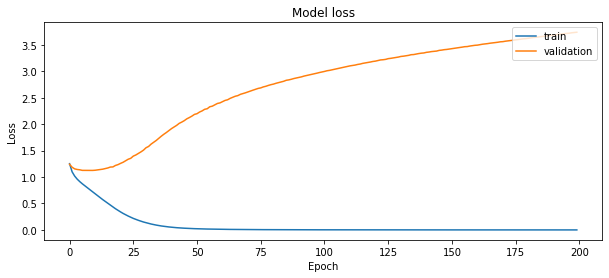

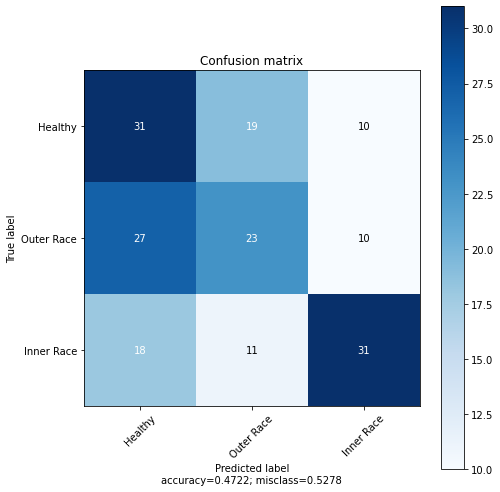

In [14]:
from utils import plot_loss_function, plot_confusion_matrix

# plot gráfico de función de pérdida
plot_loss_function(model_history, figsize=(10,4))

# plot de matriz de confusión
plot_confusion_matrix(Y_true, Y_pred, ['Healthy', 'Outer Race', 'Inner Race'], figsize=(7, 7))

---
## Model Build Template
Para poder ir modificando los hiperparámetros de nuestro modelo de manera más cómoda, a continuación se entrega un template que compila los bloques de código anteriores.

validation accuracy: 0.478



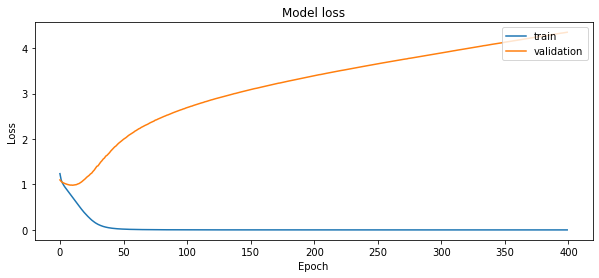

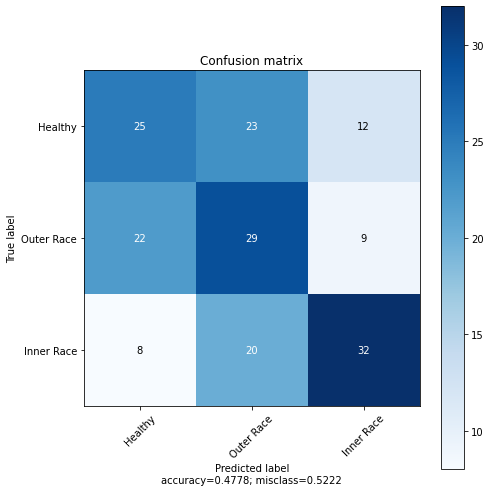

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense

from keras.optimizers import Adam

from utils import plot_loss_function, plot_confusion_matrix

# cargar archivo .npz que contiene los sets de entrenamiento
npz_dst = np.load('//content//MFPT_raw.npz')

# extraer sets de datos
X_train, Y_train = npz_dst['X_train'], npz_dst['Y_train']
X_val, Y_val = npz_dst['X_val'], npz_dst['Y_val']

# -------------------------------------------------------------------
# inicializar modelo keras.Sequential
model = Sequential()

# agregar capa Input
input_dim = (X_train.shape[1], )
model.add( Input( shape=input_dim ) )

# ahora debemos ir agregando nuestras capas Dense.
model.add( Dense(units=32, activation='relu') )
model.add( Dense(units=32, activation='relu') )

# por último debemos configurar nuestra capa de salida
labels_num = 3
model.add( Dense(units=labels_num, activation='softmax') )

# -------------------------------------------------------------------
# compilar modelo
opt = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

# entrenar modelo
model_history = model.fit(X_train, Y_train, batch_size=32, epochs=400,
                          validation_data = (X_val, Y_val), verbose=0)

# -------------------------------------------------------------------
# obtener predicciones de X_val
Y_pred = model.predict(X_val)

# transformar a non one-hot-encoding.
Y_pred = np.argmax( Y_pred, axis=-1 )
Y_true = np.argmax( Y_val, axis=-1 )

# calcular accuracy de la clasificación.
accuracy = accuracy_score(Y_true, Y_pred)
print('validation accuracy: {:1.3f}\n'.format(accuracy))

# -------------------------------------------------------------------
# plot gráfico de función de pérdida
plot_loss_function(model_history, figsize=(10,4))

# plot de matriz de confusión
plot_confusion_matrix(Y_true, Y_pred, ['Healthy', 'Outer Race', 'Inner Race'], figsize=(7, 7))